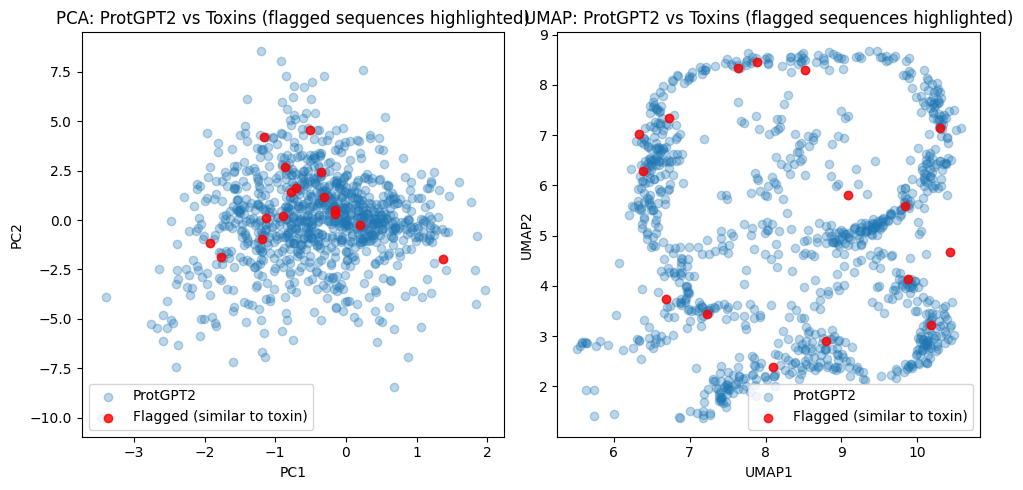

16 ProtGPT2 sequences flagged by similarity ≥ 0.2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load datasets
# ---------------------------
ai_data = pd.read_csv("protGPT2_risk_screening_t3dbcompare.csv")           # PCA/UMAP + anomaly results
similarity = pd.read_csv("protGPT2_toxin_similarity_40pct_t3dbcompare.csv")      # similarity results

# Identify flagged AI sequence indices
flagged_indices = similarity["AI_Seq_Index"].unique().tolist()

# Mark flagged sequences in AI dataset
ai_data["Flagged"] = ai_data.index.isin(flagged_indices).astype(int)

# ---------------------------
# 2. PCA plot with flagged sequences
# ---------------------------
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(ai_data["PCA1"], ai_data["PCA2"], alpha=0.3, label="ProtGPT2")
plt.scatter(ai_data.loc[ai_data["Flagged"]==1, "PCA1"],
            ai_data.loc[ai_data["Flagged"]==1, "PCA2"],
            c="red", label="Flagged (similar to toxin)", alpha=0.8)
plt.title("PCA: ProtGPT2 vs Toxins (flagged sequences highlighted)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# ---------------------------
# 3. UMAP plot with flagged sequences
# ---------------------------
plt.subplot(1,2,2)
plt.scatter(ai_data["UMAP1"], ai_data["UMAP2"], alpha=0.3, label="ProtGPT2")
plt.scatter(ai_data.loc[ai_data["Flagged"]==1, "UMAP1"],
            ai_data.loc[ai_data["Flagged"]==1, "UMAP2"],
            c="red", label="Flagged (similar to toxin)", alpha=0.8)
plt.title("UMAP: ProtGPT2 vs Toxins (flagged sequences highlighted)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()

plt.tight_layout()
plt.show()

print(f"{len(flagged_indices)} ProtGPT2 sequences flagged by similarity ≥ 0.2")


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


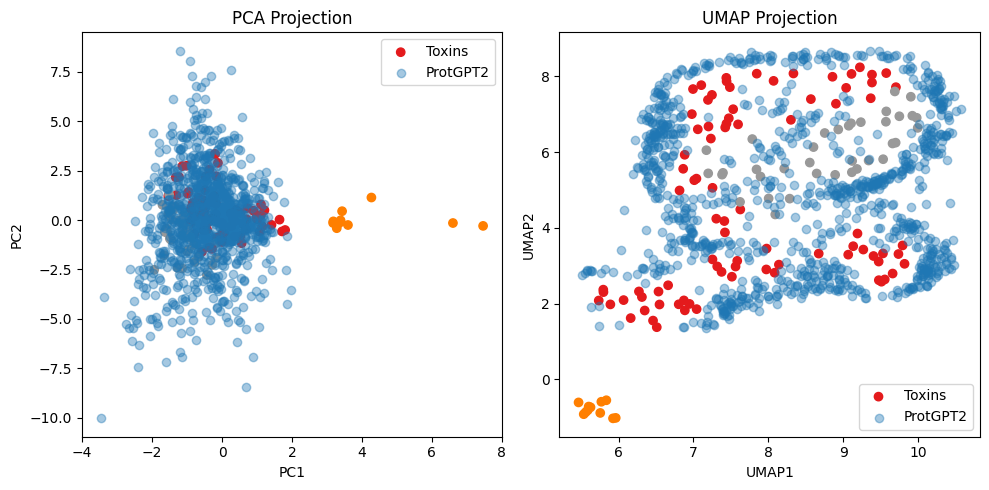

Screening complete. Results saved to protGPT2_risk_screening.csv


In [ ]:
# Install umap if not already installed
!pip install umap-learn scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import umap

# ---------------------------
# 1. Load datasets
# ---------------------------
toxins = pd.read_csv("t3db_protparam_only.csv")
ai_data = pd.read_csv("protGPT2_1000_features.csv")

# Select numeric features only
features = ["MW", "Aromaticity", "Instability", "pI", "GRAVY", "Length"]

X_tox = toxins[features].copy()
X_ai = ai_data[features].copy()

# ---------------------------
# 2. Scale features
# ---------------------------
scaler = StandardScaler()
X_tox_scaled = scaler.fit_transform(X_tox)
X_ai_scaled = scaler.transform(X_ai)

# ---------------------------
# 3. PCA embedding
# ---------------------------
pca = PCA(n_components=2, random_state=42)
pca_tox = pca.fit_transform(X_tox_scaled)
pca_ai = pca.transform(X_ai_scaled)

# ---------------------------
# 4. UMAP embedding
# ---------------------------
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_tox = umap_model.fit_transform(X_tox_scaled)
umap_ai = umap_model.transform(X_ai_scaled)

# ---------------------------
# 5. Clustering (on toxins only)
# ---------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
toxins["Cluster"] = kmeans.fit_predict(X_tox_scaled)

# ---------------------------
# 6. Anomaly detection (train on toxins, apply to AI)
# ---------------------------
ocsvm = OneClassSVM(gamma="auto").fit(X_tox_scaled)
isoforest = IsolationForest(random_state=42).fit(X_tox_scaled)

ai_data["PCA1"], ai_data["PCA2"] = pca_ai[:,0], pca_ai[:,1]
ai_data["UMAP1"], ai_data["UMAP2"] = umap_ai[:,0], umap_ai[:,1]
ai_data["OCSVM"] = ocsvm.predict(X_ai_scaled)   # -1 = outlier
ai_data["IForest"] = isoforest.predict(X_ai_scaled)  # -1 = outlier

# Save screening results
ai_data.to_csv("protGPT2_risk_screening_t3dbcompare.csv", index=False)

# ---------------------------
# 7. Visualization
# ---------------------------
plt.figure(figsize=(10,5))

# PCA plot
plt.subplot(1,2,1)
plt.scatter(pca_tox[:,0], pca_tox[:,1], c=toxins["Cluster"], cmap="Set1", label="Toxins")
plt.scatter(ai_data["PCA1"], ai_data["PCA2"], alpha=0.4, label="ProtGPT2")
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# UMAP plot
plt.subplot(1,2,2)
plt.scatter(umap_tox[:,0], umap_tox[:,1], c=toxins["Cluster"], cmap="Set1", label="Toxins")
plt.scatter(ai_data["UMAP1"], ai_data["UMAP2"], alpha=0.4, label="ProtGPT2")
plt.title("UMAP Projection")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()

plt.tight_layout()
plt.show()

print("Screening complete. Results saved to protGPT2_risk_screening.csv")


In [ ]:
# Install Biopython if not already
!pip install biopython

from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import pandas as pd
import numpy as np

# ---------------------------
# 1. Load datasets
# ---------------------------
toxins = pd.read_csv("toxdl_train_protparam.csv")     # toxin reference set
ai_data = pd.read_csv("protGPT2_1000_features.csv") # ProtGPT2 outputs

# Extract sequences
toxin_seqs = toxins["Sequence"].dropna().tolist()
ai_seqs = ai_data["Sequence"].dropna().tolist()

# ---------------------------
# 2. Function: pairwise similarity
# ---------------------------
def seq_similarity(seq1, seq2):
    """Return normalized similarity score (0–1)."""
    alignments = pairwise2.align.globalxx(seq1, seq2, score_only=True)
    max_len = max(len(seq1), len(seq2))
    return alignments / max_len if max_len > 0 else 0

# ---------------------------
# 3. Run comparisons
# ---------------------------
results = []
for i, ai_seq in enumerate(ai_seqs):
    for j, tox_seq in enumerate(toxin_seqs):
        score = seq_similarity(ai_seq, tox_seq)
        if score >= 0.4:  # paper’s cutoff threshold
            results.append({
                "AI_Seq_Index": i,
                "AI_Sequence": ai_seq,
                "Toxin_Index": j,
                "Toxin_Sequence": tox_seq,
                "Similarity": score
            })

# ---------------------------
# 4. Save and summarize
# ---------------------------
similarity_df = pd.DataFrame(results)
similarity_df.to_csv("protGPT2_toxin_similarity_40pct_toxdlcompare.csv", index=False)

print(f"Found {len(similarity_df)} ProtGPT2–toxin pairs with similarity ≥ 0.2")
print("Saved to protGPT2_toxin_similarity.csv")

# Show top 10 matches
similarity_df.sort_values("Similarity", ascending=False).head(10)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


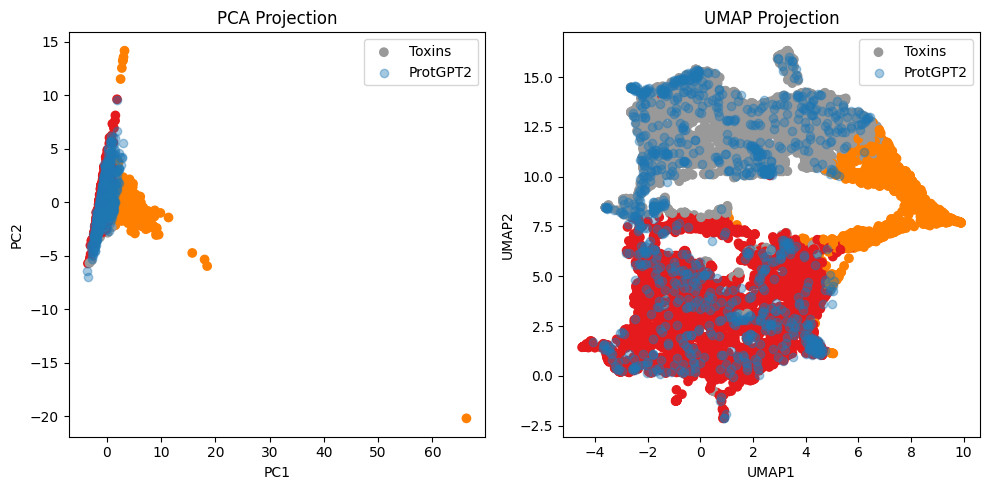

Screening complete. Results saved to protGPT2_risk_screening.csv


In [ ]:
# Install umap if not already installed
!pip install umap-learn scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import umap

# ---------------------------
# 1. Load datasets
# ---------------------------
toxins = pd.read_csv("t3db_protparam_only")
ai_data = pd.read_csv("protGPT2_1000_features.csv")

# Select numeric features only
features = ["MW", "Aromaticity", "Instability", "pI", "GRAVY", "Length"]

X_tox = toxins[features].copy()
X_ai = ai_data[features].copy()

# ---------------------------
# 2. Scale features
# ---------------------------
scaler = StandardScaler()
X_tox_scaled = scaler.fit_transform(X_tox)
X_ai_scaled = scaler.transform(X_ai)

# ---------------------------
# 3. PCA embedding
# ---------------------------
pca = PCA(n_components=2, random_state=42)
pca_tox = pca.fit_transform(X_tox_scaled)
pca_ai = pca.transform(X_ai_scaled)

# ---------------------------
# 4. UMAP embedding
# ---------------------------
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_tox = umap_model.fit_transform(X_tox_scaled)
umap_ai = umap_model.transform(X_ai_scaled)

# ---------------------------
# 5. Clustering (on toxins only)
# ---------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
toxins["Cluster"] = kmeans.fit_predict(X_tox_scaled)

# ---------------------------
# 6. Anomaly detection (train on toxins, apply to AI)
# ---------------------------
ocsvm = OneClassSVM(gamma="auto").fit(X_tox_scaled)
isoforest = IsolationForest(random_state=42).fit(X_tox_scaled)

ai_data["PCA1"], ai_data["PCA2"] = pca_ai[:,0], pca_ai[:,1]
ai_data["UMAP1"], ai_data["UMAP2"] = umap_ai[:,0], umap_ai[:,1]
ai_data["OCSVM"] = ocsvm.predict(X_ai_scaled)   # -1 = outlier
ai_data["IForest"] = isoforest.predict(X_ai_scaled)  # -1 = outlier

# Save screening results
ai_data.to_csv("protGPT2_risk_screening_t3dbcompare.csv", index=False)

# ---------------------------
# 7. Visualization
# ---------------------------
plt.figure(figsize=(10,5))

# PCA plot
plt.subplot(1,2,1)
plt.scatter(pca_tox[:,0], pca_tox[:,1], c=toxins["Cluster"], cmap="Set1", label="Toxins")
plt.scatter(ai_data["PCA1"], ai_data["PCA2"], alpha=0.4, label="ProtGPT2")
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# UMAP plot
plt.subplot(1,2,2)
plt.scatter(umap_tox[:,0], umap_tox[:,1], c=toxins["Cluster"], cmap="Set1", label="Toxins")
plt.scatter(ai_data["UMAP1"], ai_data["UMAP2"], alpha=0.4, label="ProtGPT2")
plt.title("UMAP Projection")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()

plt.tight_layout()
plt.show()

print("Screening complete. Results saved to protGPT2_risk_screening.csv")


In [ ]:
# Install Biopython if not already
!pip install biopython

from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import pandas as pd
import numpy as np

# ---------------------------
# 1. Load datasets
# ---------------------------
toxins = pd.read_csv("t3db_protparam_only.csv")     # toxin reference set
ai_data = pd.read_csv("protGPT2_1000_features.csv") # ProtGPT2 outputs

# Extract sequences
toxin_seqs = toxins["Sequence"].dropna().tolist()
ai_seqs = ai_data["Sequence"].dropna().tolist()

# ---------------------------
# 2. Function: pairwise similarity
# ---------------------------
def seq_similarity(seq1, seq2):
    """Return normalized similarity score (0–1)."""
    alignments = pairwise2.align.globalxx(seq1, seq2, score_only=True)
    max_len = max(len(seq1), len(seq2))
    return alignments / max_len if max_len > 0 else 0

# ---------------------------
# 3. Run comparisons
# ---------------------------
results = []
for i, ai_seq in enumerate(ai_seqs):
    for j, tox_seq in enumerate(toxin_seqs):
        score = seq_similarity(ai_seq, tox_seq)
        if score >= 0.4:  # paper’s cutoff threshold
            results.append({
                "AI_Seq_Index": i,
                "AI_Sequence": ai_seq,
                "Toxin_Index": j,
                "Toxin_Sequence": tox_seq,
                "Similarity": score
            })

# ---------------------------
# 4. Save and summarize
# ---------------------------
similarity_df = pd.DataFrame(results)
similarity_df.to_csv("protGPT2_toxin_similarity_40pct_t3dbcompare.csv", index=False)

print(f"Found {len(similarity_df)} ProtGPT2–toxin pairs with similarity ≥ 0.2")
print("Saved to protGPT2_toxin_similarity.csv")

# Show top 10 matches
similarity_df.sort_values("Similarity", ascending=False).head(10)


Found 16 ProtGPT2–toxin pairs with similarity ≥ 0.2
Saved to protGPT2_toxin_similarity.csv


,AI_Seq_Index,AI_Sequence,Toxin_Index,Toxin_Sequence,Similarity
3,237,VIFWPLFLSVR,7,RIKIGLFDQLSRL,0.461538
8,544,IYKHLKQLNL,7,RIKIGLFDQLSRL,0.461538
12,794,ILIILVFLIFYLL,7,RIKIGLFDQLSRL,0.461538
4,315,QDIQAFLKN,53,QPSKDAFIGLM,0.454545
15,929,IKHYAILKGFTSNP,7,RIKIGLFDQLSRL,0.428571
1,167,QIIEALGRVKDYVDKCNAAFGVKP,79,MAQDIISTIGDLVKWIIDTVNKFTKK,0.423077
5,402,IEKGEIDAGVVL,53,QPSKDAFIGLM,0.416667
0,52,TLKAAVDAGLAK,53,QPSKDAFIGLM,0.416667
13,805,QKARGYEQLLEL,53,QPSKDAFIGLM,0.416667
6,523,MDGMTACKQIKALYPNIKVILSSGYFLEGTAQEIQEQGAAGFIQKP...,6,MFKQLILLALAAVFLLINISSAEPAAEPNANAEPLAEASAEPRIKI...,0.403226


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


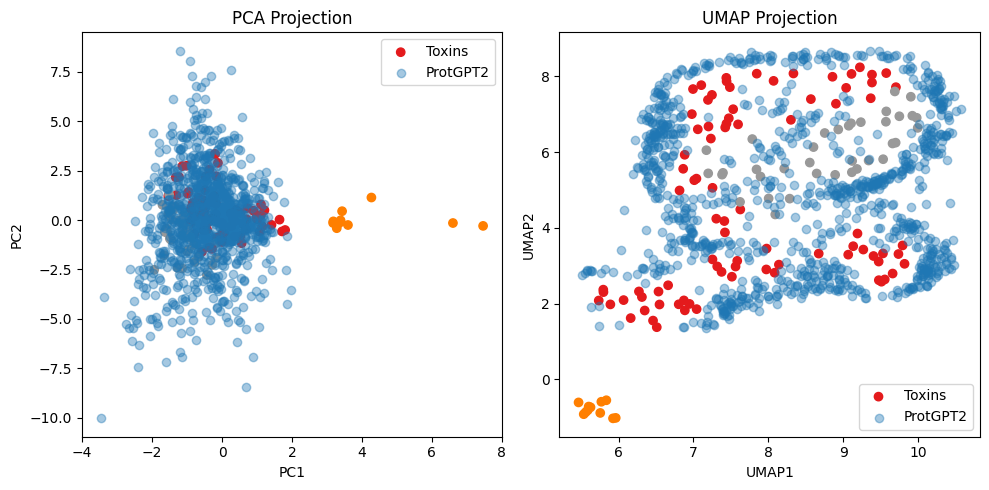

Screening complete. Results saved to protGPT2_risk_screening.csv


In [ ]:
# Install umap if not already installed
!pip install umap-learn scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import umap

# ---------------------------
# 1. Load datasets
# ---------------------------
toxins = pd.read_csv("t3db_protparam_only.csv")
ai_data = pd.read_csv("protGPT2_1000_features.csv")

# Select numeric features only
features = ["MW", "Aromaticity", "Instability", "pI", "GRAVY", "Length"]

X_tox = toxins[features].copy()
X_ai = ai_data[features].copy()

# ---------------------------
# 2. Scale features
# ---------------------------
scaler = StandardScaler()
X_tox_scaled = scaler.fit_transform(X_tox)
X_ai_scaled = scaler.transform(X_ai)

# ---------------------------
# 3. PCA embedding
# ---------------------------
pca = PCA(n_components=2, random_state=42)
pca_tox = pca.fit_transform(X_tox_scaled)
pca_ai = pca.transform(X_ai_scaled)

# ---------------------------
# 4. UMAP embedding
# ---------------------------
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_tox = umap_model.fit_transform(X_tox_scaled)
umap_ai = umap_model.transform(X_ai_scaled)

# ---------------------------
# 5. Clustering (on toxins only)
# ---------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
toxins["Cluster"] = kmeans.fit_predict(X_tox_scaled)

# ---------------------------
# 6. Anomaly detection (train on toxins, apply to AI)
# ---------------------------
ocsvm = OneClassSVM(gamma="auto").fit(X_tox_scaled)
isoforest = IsolationForest(random_state=42).fit(X_tox_scaled)

ai_data["PCA1"], ai_data["PCA2"] = pca_ai[:,0], pca_ai[:,1]
ai_data["UMAP1"], ai_data["UMAP2"] = umap_ai[:,0], umap_ai[:,1]
ai_data["OCSVM"] = ocsvm.predict(X_ai_scaled)   # -1 = outlier
ai_data["IForest"] = isoforest.predict(X_ai_scaled)  # -1 = outlier

# Save screening results
ai_data.to_csv("protGPT2_risk_screening.csv", index=False)

# ---------------------------
# 7. Visualization
# ---------------------------
plt.figure(figsize=(10,5))

# PCA plot
plt.subplot(1,2,1)
plt.scatter(pca_tox[:,0], pca_tox[:,1], c=toxins["Cluster"], cmap="Set1", label="Toxins")
plt.scatter(ai_data["PCA1"], ai_data["PCA2"], alpha=0.4, label="ProtGPT2")
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# UMAP plot
plt.subplot(1,2,2)
plt.scatter(umap_tox[:,0], umap_tox[:,1], c=toxins["Cluster"], cmap="Set1", label="Toxins")
plt.scatter(ai_data["UMAP1"], ai_data["UMAP2"], alpha=0.4, label="ProtGPT2")
plt.title("UMAP Projection")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()

plt.tight_layout()
plt.show()

print("Screening complete. Results saved to protGPT2_risk_screening.csv")


In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.1 MB/s eta 0:00:00


In [ ]:
# Install ProtGPT2 + dependencies
!pip install git+https://github.com/agemagician/ProtGPT2.git transformers biopython

from transformers import AutoTokenizer, AutoModelWithLMHead
import torch
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd

# ---------------------------
# Load ProtGPT2 model + tokenizer
# ---------------------------
tokenizer = AutoTokenizer.from_pretrained("nferruz/ProtGPT2")
model = AutoModelWithLMHead.from_pretrained("nferruz/ProtGPT2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ---------------------------
# Function: generate a protein sequence
# ---------------------------
def generate_protein(max_length=200):
    # input = single space, as required
    input_ids = tokenizer.encode(" ", return_tensors="pt").to(device)
    sample_output = model.generate(
        input_ids,
        do_sample=True,
        max_length=max_length,
        top_k=950,
        top_p=0.96,
        temperature=0.7,
        repetition_penalty=1.2,
    )
    seq = tokenizer.decode(sample_output[0], skip_special_tokens=True)
    # remove whitespace & linebreaks
    return seq.replace(" ", "").replace("\n", "")

# ---------------------------
# Function: extract biochemical features
# ---------------------------
def extract_features(seq):
    analysed_seq = ProteinAnalysis(seq)
    return {
        "Sequence": seq,
        "MW": analysed_seq.molecular_weight(),
        "Aromaticity": analysed_seq.aromaticity(),
        "Instability": analysed_seq.instability_index(),
        "pI": analysed_seq.isoelectric_point(),
        "GRAVY": analysed_seq.gravy(),
        "Length": len(seq)
    }

# ---------------------------
# Generate 1,000 valid sequences
# ---------------------------
all_features = []
while len(all_features) < 500:
    seq = generate_protein()
    if len(seq) >= 5:   # enforce minimum length constraint
        try:
            feats = extract_features(seq)
            all_features.append(feats)
        except Exception:
            # skip problematic sequences
            continue

df = pd.DataFrame(all_features)
df.to_csv("protGPT2_500_features3.csv", index=False)

print("Generated and analyzed 1,000 ProtGPT2 sequences (≥5 residues).")
print("Saved to protGPT2_500_features3.csv")
